# Regressão Logística

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

### Implementando com numpy e scipy

Vamos implementar o treinamento da regressão logística e entender como funciona a otimização da função de máxima verossimilhança

In [3]:
def calculate_logistic_function(x, coefficients):
    return np.exp(x.dot(coefficients)) / (1 + np.exp(x.dot(coefficients)))

In [4]:
def calculate_log_likelihood(coefficients, x, y):
    a = calculate_logistic_function(x, coefficients)
    r = y.dot(np.log(a)) + (1 - y).dot(np.log(1 - a))
    return -np.sum(r)

In [5]:
def calculate_predictions(x, coefficients):
    logistic_result = calculate_logistic_function(x, coefficients)
    return np.where(logistic_result > 0.5, 1, 0)

In [6]:
def calculate_error(predicted, actual):
    return np.average(np.abs(predicted - actual))

In [7]:
df = pd.read_excel("Absenteeism_at_work.xlsx", index_col=0)
df.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Social drinker,Social smoker
ID,,,,,,,,,,,,,,,,,,,,
3,13,3,3,2,179,51,18,38,343253,95,0,1,0,0,89,170,31,24,1,0
3,28,6,2,3,179,51,18,38,253957,95,0,1,0,0,89,170,31,4,1,0
33,23,9,6,4,248,25,14,47,241476,92,0,1,2,1,86,165,32,1,0,0
28,25,3,5,2,225,26,9,28,222196,99,0,1,1,2,69,169,24,2,0,0
10,22,12,4,4,361,52,3,28,261306,97,0,1,1,4,80,172,27,8,1,0


In [8]:
social_drinker = df.loc[:, "Social drinker"]
social_smoker = df.loc[:, "Social smoker"]
df.drop(columns=["Social drinker", "Social smoker"], inplace=True)

df /= df.max()

test_x = df.iloc[:195, :]
test_y = social_drinker[:195]

train_x = df.iloc[195:, :]
train_y = social_drinker[195:]

n_variables = train_x.shape[1]
initial_guess = np.ones(n_variables + 1)

train_x_bias = np.concatenate([np.ones((train_x.shape[0], 1)), train_x], axis=1)
test_x_bias = np.concatenate([np.ones((test_x.shape[0], 1)), test_x], axis=1)

res = minimize(calculate_log_likelihood, initial_guess, args=(train_x_bias, train_y))
print(res.x)

training_prediction = calculate_predictions(train_x_bias, res.x)
print(calculate_error(training_prediction, train_y))

testing_prediction = calculate_predictions(test_x_bias, res.x)
print(calculate_error(testing_prediction, test_y))

[-21.99419229   0.66297383   0.7672188    0.44682229  -0.37901427
   4.63741951   5.5989203   12.14963648  -3.41635427  -0.4873736
  -5.91313731   0.56531909  -7.9677492    1.79925962  -1.17382132
  34.93375068  16.75204771 -27.33316916   1.18798019]
0.05152671755725191
0.06666666666666667


### Usando a biblioteca statsmodels

#### Exemplo 1

Vamos utilizar o dataset UCLA (`graduate_schools.csv`). Esse dataset contém as seguintes informações:

- **Admit**: variável binária indicando se o estudante foi ou não admitido na universidade
- **GRE**: variável contínua indicando a nota do estudante no GRE
- **GPA**: variável contínua indicanto a média na graduação
- **Rank**: variável categórica indicando o nível de prestígio da universidade que o estudante cursou a graduação (1: maior prestígio - 4: menor prestígio)

Nosso objetivo é identificar fatores que podem influenciar a admissão em um mestrado/doutorado em uma universidade

In [9]:
df = pd.read_csv('graduate_schools.csv', sep=' ')

In [10]:
df.head()

,admit,gre,gpa,rank
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4.00,1
4,1,640,3.19,4
5,0,520,2.93,4


In [11]:
df.columns = ['admit', 'gre', 'gpa', 'prestige']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 4 columns):
admit       400 non-null int64
gre         400 non-null int64
gpa         400 non-null float64
prestige    400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 15.6 KB


In [13]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


Podemos extrair algumas informações dessas métricas:

- A variável `admit` está sendo tratada como contínua por enquanto e a média indica que aproximadamente 31.75% dos estudantes que aplicam para uma universidade (mestrado/doutorado) são aprovados
- A variável `prestige` parece estar balanceada entre universidades prestigiadas e não prestigiadas se considerarmos que a média com o mesmo número de amostras em cada categoria seria 2.5. 

Podemos verificar também se temos dados em todas as combinações de admissão e prestígio

In [14]:
pd.crosstab(df['admit'], df['prestige'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


Podemos traçar o histograma das variáveis como uma forma de exploração dos dados, pois são rápidos de interpretar e fornecem uma boa representação visual para o problema

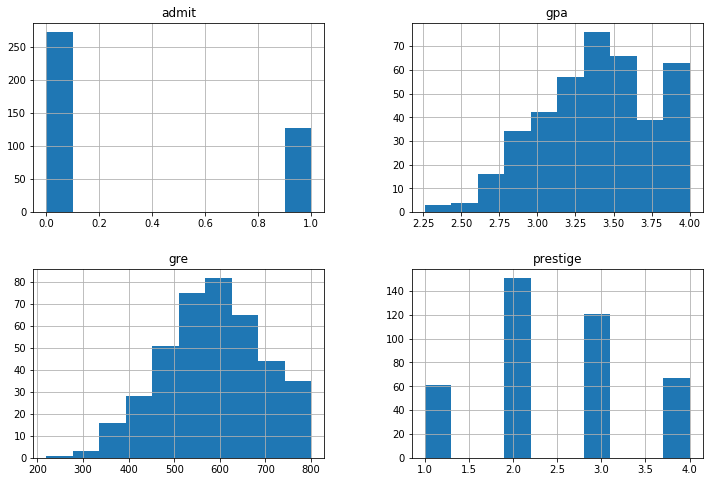

In [15]:
df.hist();

Agora precisamos dummificar nossa variável preditora categórica

In [16]:
pd.get_dummies(df['prestige'], prefix='prestige')

,prestige_1,prestige_2,prestige_3,prestige_4
1,0,0,1,0
2,0,0,1,0
3,1,0,0,0
4,0,0,0,1
5,0,0,0,1
...,...,...,...,...
396,0,1,0,0
397,0,0,1,0
398,0,1,0,0
399,0,1,0,0


In [17]:
dummy_prestige = pd.get_dummies(df['prestige'], prefix='prestige', drop_first=True)
dummy_prestige.head()

,prestige_2,prestige_3,prestige_4
1,0,1,0
2,0,1,0
3,0,0,0
4,0,0,1
5,0,0,1


Podemos concatenar os dataframes para incluir nossa variável dummificada

In [18]:
columns_to_keep = ['admit', 'gre', 'gpa']
data = df[columns_to_keep].join(dummy_prestige)
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4
1,0,380,3.61,0,1,0
2,1,660,3.67,0,1,0
3,1,800,4.00,0,0,0
4,1,640,3.19,0,0,1
5,0,520,2.93,0,0,1


Então vamos tentar prever a admissão usando as colunas `gre`, `gpa` e as variáveis dummy `prestige_2`, `prestige_3`, `prestige_4`. Vamos tratar o `prestige_1` como nosso baseline e excluí-lo do ajuste do modelo. Lembrando que fazemos isso para prevenir o problema de multicolinearidade.

Vamos adicionar a constante para incluir o termo da interceptação

In [19]:
data = sm.add_constant(data)
data.head()

/Users/strachan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,admit,gre,gpa,prestige_2,prestige_3,prestige_4
1,1.0,0,380,3.61,0,1,0
2,1.0,1,660,3.67,0,1,0
3,1.0,1,800,4.00,0,0,0
4,1.0,1,640,3.19,0,0,1
5,1.0,0,520,2.93,0,0,1


In [20]:
train_columns = data.columns[data.columns != 'admit']
train_columns

Index(['const', 'gre', 'gpa', 'prestige_2', 'prestige_3', 'prestige_4'], dtype='object')

In [21]:
logit = sm.Logit(data['admit'], data[train_columns]).fit()
logit.summary2()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.083     
Dependent Variable: admit            AIC:              470.5175  
Date:               2020-02-10 19:49 BIC:              494.4663  
No. Observations:   400              Log-Likelihood:   -229.26   
Df Model:           5                LL-Null:          -249.99   
Df Residuals:       394              LLR p-value:      7.5782e-08
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -3.9900    1.1400  -3.5001  0.0005  -6.2242  -1.7557
gre            0.0023    0.0011   2.0699  0.0385   0.0001   0.0044
gpa            0.8040    0.3318   2.4231  0.0154   0.1537   1.4544
prestige_2    -0.6754    0.3165  -2.1342  0.0328  -1.2958  -0.0551
prestige_3    -1.3402    0.3453  -3.8812  0.0001  -2.0170  -0.6634
prestige_4    -1.5515    0.4178  -3.7131  0.0002  -2.3704  -0.7325
=================================================================

"""

In [22]:
print(f'Deviance nulo: {2*(1 - logit.llnull)} com {data.shape[0] - 1} graus de liberdade')
print(f'Deviance residual: {2*(1 - logit.llf)} com {data.shape[0] - len(train_columns)} graus de liberdade')

Deviance nulo: 501.97651762186103 com 399 graus de liberdade
Deviance residual: 460.51749247589896 com 394 graus de liberdade


#### Interpretando os coeficientes

- CONST: O log da chance de um estudante ser admitido para uma pós graduação quando eles cursaram a graduação em uma universidade muito prestigiada e recebeu 0 no GRE e 0 no GPA é aproximadamente -3.99

- GRE: Para cada ponto adicional que o estudante tira no GRE, o log da chance de ser admitido para uma pós graduação aumenta aproximadamente 0.002, se todas as outras variáveis permanecerem constante

- GPA: Para cada ponto adicional que o estudante tira no GPA, o log da chance de ser admitido para uma pós graduação aumenta aproximadamente 0.804, se todas as outras variáveis permanecerem constante

- Prestige: O log da chance associado a ter frequentado uma graduação em uma universidade com prestígio 2, 3, e 4, quando comparado com uma universidade de prestígio 1 é de aproximadamente -0.675, -1.340, e -1.552, respectivamente, se todas as outras variáveis permanecerem constante

Podemos analisar a relação log da chance e chance

In [23]:
pd.DataFrame({'Log_da_Chance': logit.params.values, 'Chance': np.exp(logit.params.values)})

,Log_da_Chance,Chance
0,-3.989979,0.018500
1,0.002264,1.002267
2,0.804038,2.234545
3,-0.675443,0.508931
4,-1.340204,0.261792
5,-1.551464,0.211938


Podemos construir um intervalo de confiança para a escala da chance:

In [24]:
np.exp(logit.conf_int())

,0,1
const,0.001981,0.172783
gre,1.000120,1.004418
gpa,1.166122,4.281877
prestige_2,0.273692,0.946358
prestige_3,0.133055,0.515089
prestige_4,0.093443,0.480692


Vamos testar agora se o prestígio da universidade da graduação do estudante tem alguma influência no modelo? Vamos fazer um teste de queda do desvio

In [25]:
logit_no_prestige = sm.Logit(data['admit'], data[['const', 'gre', 'gpa']]).fit()
logit_no_prestige.summary2()

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.039     
Dependent Variable: admit            AIC:              486.3440  
Date:               2020-02-10 19:49 BIC:              498.3184  
No. Observations:   400              Log-Likelihood:   -240.17   
Df Model:           2                LL-Null:          -249.99   
Df Residuals:       397              LLR p-value:      5.4557e-05
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -4.9494     1.0751   -4.6037   0.0000   -7.0565   -2.8422
gre        0.0027     0.0011    2.5444   0.0109    0.0006    0.0048
gpa        0.7547     0.3196    2.3615   0.0182    0.1283    1.3811
=================================================================

"""

Aplicando o teste $\chi^2$

In [26]:
p_value = stats.chi2.sf(x=2*(1 - logit_no_prestige.llf) - 2*(1 - logit.llf),
                        df=logit_no_prestige.df_resid - logit.df_resid)
p_value

7.088456177668665e-05

O p-valor ê extremamente baixo (<0.0005). Logo, nós temos evidências para concluir que o modelo com a variável categórica `prestige` é melhor que o modelo sem essa variável

Como a probabilidade de admissão muda com o prestígio para um estudante que tem um GRE na média e um GPA na média

In [27]:
new_data = pd.DataFrame({'prestige': [1, 2, 3, 4]})
new_data['gre'] = data['gre'].mean()
new_data['gpa'] = data['gpa'].mean()
new_data.head()

,prestige,gre,gpa
0,1,587.7,3.3899
1,2,587.7,3.3899
2,3,587.7,3.3899
3,4,587.7,3.3899


In [28]:
dummy_prestige = pd.get_dummies(new_data['prestige'], prefix='prestige', drop_first=True)
new_data = new_data[['gre', 'gpa']].join(dummy_prestige)
new_data.head()

,gre,gpa,prestige_2,prestige_3,prestige_4
0,587.7,3.3899,0,0,0
1,587.7,3.3899,1,0,0
2,587.7,3.3899,0,1,0
3,587.7,3.3899,0,0,1


In [29]:
new_data = sm.add_constant(new_data, has_constant='add')
new_data.head()

,const,gre,gpa,prestige_2,prestige_3,prestige_4
0,1.0,587.7,3.3899,0,0,0
1,1.0,587.7,3.3899,1,0,0
2,1.0,587.7,3.3899,0,1,0
3,1.0,587.7,3.3899,0,0,1


In [30]:
logit.predict(new_data)

0    0.516602
1    0.352285
2    0.218612
3    0.184668
dtype: float64

In [31]:
new_data['P_Admit'] = logit.predict(new_data)
new_data

,const,gre,gpa,prestige_2,prestige_3,prestige_4,P_Admit
0,1.0,587.7,3.3899,0,0,0,0.516602
1,1.0,587.7,3.3899,1,0,0,0.352285
2,1.0,587.7,3.3899,0,1,0,0.218612
3,1.0,587.7,3.3899,0,0,1,0.184668


Podemos analisar a matriz de confusão

In [32]:
results = pd.DataFrame(logit.pred_table(), columns=[['Prediction', 'Prediction'],['0', '1']], index=[['Truth', 'Truth'], ['0', '1']])
results

Prediction      
                 0     1
Truth 0      254.0  19.0
      1       97.0  30.0

Parece que esse modelo cometeu bastante erros (116 de 400). O resultado não é bom. Vamos explorar um pouco mais, podemos olhar o teste geral do desvio:

In [33]:
p_value = stats.chi2.sf(x=2*(1 - logit.llf),
                        df=logit.df_resid)
p_value

0.011560246784767301

O p-valor para o teste geral do desvio é <0.05, indicando que o modelo não é apropriado. Podemos olhar o pseudo $R^2$:

In [34]:
logit.prsquared

0.08292194470084713

Somente 8.29% da variabilidade da admissão parece ser explicada pelos preditores do nosso modelo. Apesar do modelo ser válido, parece que não é muito informativo.

O que encontramos então? O modelo geral que criamos não nos dá muito poder de predição para saber se um estudante será admitido ou nãp para uma pós-graduação

In [35]:
data['admit'].value_counts()

0    273
1    127
Name: admit, dtype: int64

In [36]:
results.sum(axis=1)

Truth  0    273.0
       1    127.0
dtype: float64

Temos 273 estudantes que não foram admitidos e 127 que foram

In [37]:
results.sum(axis=0)

Prediction  0    351.0
            1     49.0
dtype: float64

Porém o modelo previu que 351 estudantes não serão admitidos e que somente 49 serão

In [38]:
results

Prediction      
                 0     1
Truth 0      254.0  19.0
      1       97.0  30.0

A matriz de confusão mostra que temos uma acurácia de $\frac{254+30}{400} = 71\%$

Porém, se tivessemos previsto que todos não seriam admitidos, nossa acurácia seria de $\frac{273}{400} = 68.25\%$

Por isso que nosso teste geral de desvio foi insignificativo

#### Exemplo 2

Vamos utilizar um dataset de um resultado de um pesquisa realizada entre 1972 e 1981 na Holando com o objetivo de entender se ter um passarinho em casa é um risco para câncer de pulmão. As variáveis incluem se o indivíduo teve ou não câncer de pulmão, se eles tinham ou não um passarinho, o sexo, status socio-econômico, idade, quantos anos fumam, e a média que fumam 

In [78]:
df = pd.read_csv('lung_cancer.csv', index_col=0)
df.head()

,LC,FM,SS,BK,AG,YR,CD
1,LungCancer,Male,Low,Bird,37,19,12
2,LungCancer,Male,Low,Bird,41,22,15
3,LungCancer,Male,High,NoBird,43,19,15
4,LungCancer,Male,Low,Bird,46,24,15
5,LungCancer,Male,Low,Bird,49,31,20


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 1 to 147
Data columns (total 7 columns):
LC    147 non-null object
FM    147 non-null object
SS    147 non-null object
BK    147 non-null object
AG    147 non-null int64
YR    147 non-null int64
CD    147 non-null int64
dtypes: int64(3), object(4)
memory usage: 9.2+ KB


In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AG,147.0,56.965986,7.348856,37.0,52.0,59.0,63.0,67.0
YR,147.0,27.850340,13.975690,0.0,20.0,30.0,39.0,50.0
CD,147.0,15.748299,9.703723,0.0,10.0,15.0,20.0,45.0


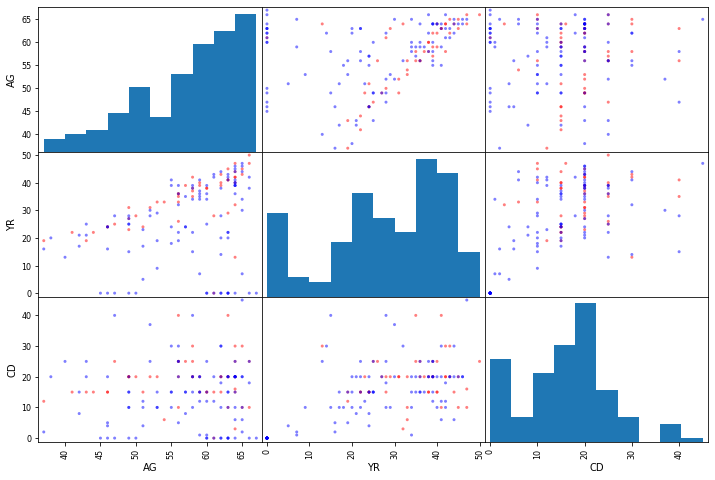

In [81]:
colors = df['LC'].map(lambda x: 'red' if x == 'LungCancer' else 'blue')
pd.plotting.scatter_matrix(df, color=colors);

Vamos dummificar as variáveis categóricas

In [88]:
dummy_gender = pd.get_dummies(df['FM'], prefix='FM', drop_first=False)
dummy_gender.sample(5)

,FM_Female,FM_Male
42,1,0
36,0,1
137,1,0
94,0,1
21,0,1


In [89]:
dummy_social_econ_status = pd.get_dummies(df['SS'], prefix='SS', drop_first=False)
dummy_social_econ_status.sample(5)

,SS_High,SS_Low
59,0,1
61,1,0
139,0,1
102,1,0
114,0,1


In [90]:
dummy_bird = pd.get_dummies(df['BK'], prefix='BK', drop_first=False)
dummy_bird.sample(5)

,BK_Bird,BK_NoBird
46,1,0
147,0,1
110,0,1
12,0,1
50,0,1


In [92]:
columns_to_keep = ['AG', 'YR', 'CD']
data = df[columns_to_keep].join(dummy_gender['FM_Female']).join(dummy_social_econ_status['SS_High']).join(dummy_bird['BK_Bird'])
data = sm.add_constant(data)
data.head()

,const,AG,YR,CD,FM_Female,SS_High,BK_Bird
1,1.0,37,19,12,0,0,1
2,1.0,41,22,15,0,0,1
3,1.0,43,19,15,0,1,0
4,1.0,46,24,15,0,0,1
5,1.0,49,31,20,0,0,1


In [93]:
dummy_lung_cancer = pd.get_dummies(df['LC'])
dummy_lung_cancer.sample(5)

,LungCancer,NoCancer
76,0,1
116,0,1
33,1,0
63,0,1
132,0,1


Vamos criar um modelo com todas as variáveis

In [105]:
logit = sm.GLM(dummy_lung_cancer['LungCancer'], data, family=sm.families.Binomial()).fit();
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            168.1984 
Link Function:      logit            BIC:            -544.4621
Dependent Variable: LungCancer       Log-Likelihood: -77.099  
Date:               2020-02-10 20:15 LL-Null:        -93.568  
No. Observations:   147              Deviance:       154.20   
Df Model:           6                Pearson chi2:   141.     
Df Residuals:       140              Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
const       -1.9374    1.8043  -1.0738  0.2829  -5.4736  1.5989
AG          -0.0398    0.0355  -1.1205  0.2625  -0.1093  0.0298
YR           0.0729    0.0265   2.7511  0.0059   0.0210  0.1248
CD           0.0260    0.0255   1.0193  0.3081  -0.0240  0.0760
FM_Female    0.5613    0.5312   1.0567  0.2907  -0.4798  1.6023
SS_High      0.1054    0.4688   0.2249  0.8221  -0.8135  1.0244
BK_Bird      1.3626    0.4113   3.3131  0.0009   0.5565  2.1687
==============================================================

"""

Vamos analisar o teste geral de desvio para saber se teve um bom ajuste

- H0: O modelo de regressão logística é apropriado
- H1: O modelo de regressão logística não é apropriado

In [109]:
p_value = stats.chi2.sf(x=logit.deviance,
                        df=logit.df_resid)
p_value

0.19463355234238075

O p-valor para o teste é quase 0.20, que é maior que o valor de corte de 0.05. Não temos evidências para rejeitar a hipótese nula de que o modelo é apropriado

Vamos interpretar o coeficiente do sexo

O log da chance de ter um cancer de pulmão aumentam de 0.56 se você for do sexo feminino se comparado com o masculino, mantendo todas as outras variáveis constantes

Agora vamos ajustar um modelo que contém todas as variáveis exceto a variável que indica se tem um passarinho e fazer o teste de ajuste

In [111]:
data_no_bk = data[data.columns[data.columns != 'BK_Bird']]
data_no_bk.head()

,const,AG,YR,CD,FM_Female,SS_High
1,1.0,37,19,12,0,0
2,1.0,41,22,15,0,0
3,1.0,43,19,15,0,1
4,1.0,46,24,15,0,0
5,1.0,49,31,20,0,0


In [112]:
logit_no_bk = sm.GLM(dummy_lung_cancer['LungCancer'], data_no_bk, family=sm.families.Binomial()).fit();
logit_no_bk.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            177.8684 
Link Function:      logit            BIC:            -537.7826
Dependent Variable: LungCancer       Log-Likelihood: -82.934  
Date:               2020-02-10 20:25 LL-Null:        -93.568  
No. Observations:   147              Deviance:       165.87   
Df Model:           5                Pearson chi2:   151.     
Df Residuals:       141              Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
const       -0.2972    1.6600  -0.1791  0.8579  -3.5508  2.9563
AG          -0.0580    0.0343  -1.6895  0.0911  -0.1253  0.0093
YR           0.0796    0.0264   3.0176  0.0025   0.0279  0.1312
CD           0.0198    0.0242   0.8165  0.4142  -0.0277  0.0672
FM_Female    0.7492    0.5050   1.4836  0.1379  -0.2406  1.7390
SS_High     -0.0730    0.4389  -0.1664  0.8679  -0.9333  0.7872
==============================================================

"""

In [113]:
p_value = stats.chi2.sf(x=logit_no_bk.deviance,
                        df=logit_no_bk.df_resid)
p_value

0.07479572277098803

O p-valor para o teste geral de ajuste é de 0.07, que é maior que o nosso valor de corte de 0.05. Nós não temos evidências para rejeitar a hipótese nula de que o modelo é apropriado 

Agora vamos conduzir um teste de queda do desvio entre esses dois modelos que construímos

In [114]:
p_value = stats.chi2.sf(x=logit_no_bk.deviance - logit.deviance,
                        df=logit_no_bk.df_resid - logit.df_resid)
p_value

0.0006351719720000817

O p-valor para o teste de queda do desvio é <0.001, que é significante. Nós rejeitamos a hipótese nula de que o coeficiente da variável de ter um passarinho é 0, e concluímos que tendo essa variável no modelo melhora o nosso ajuste. Ou seja, o modelo completo é melhor que o reduzido

Agora vamos ajustar um novo modelo somente com as variáveis de ter um passarinho e quantos anos a pessoa fuma

In [120]:
data_bird_years_smoking = data[['BK_Bird', 'YR', 'const']]
data_bird_years_smoking.head()

,BK_Bird,YR,const
1,1,19,1.0
2,1,22,1.0
3,0,19,1.0
4,1,24,1.0
5,1,31,1.0


In [146]:
logit_bird_years_smoking = sm.GLM(dummy_lung_cancer['LungCancer'], data_bird_years_smoking, family=sm.families.Binomial()).fit();
logit_bird_years_smoking.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            164.1144 
Link Function:      logit            BIC:            -560.5079
Dependent Variable: LungCancer       Log-Likelihood: -79.057  
Date:               2020-02-10 21:13 LL-Null:        -93.568  
No. Observations:   147              Deviance:       158.11   
Df Model:           2                Pearson chi2:   139.     
Df Residuals:       144              Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
BK_Bird     1.4756    0.3959   3.7272  0.0002   0.6996   2.2515
YR          0.0582    0.0168   3.4578  0.0005   0.0252   0.0913
const      -3.1802    0.6364  -4.9968  0.0000  -4.4275  -1.9328
==============================================================

"""

Vamos fazer o mesmo teste de queda no desvio mas agora levando em consideração o modelo completo e esse modelo que acabamos de ajustar

In [135]:
p_value = stats.chi2.sf(x=logit_bird_years_smoking.deviance - logit.deviance,
                        df=logit_bird_years_smoking.df_resid - logit.df_resid)
p_value

0.4174943524634598

O p-valor do teste de queda do desvio é bem grande (0.4175), indicando que a hipótese nula que os coeficientes do sexo, status sócio-econômico, idade e média de cigarros estão em conjunto não adicionando nenhum poder preditivo em nossa análise. O modelo reduzido é suficiente.   

Vamos comparar os modelos olhando as métricas AIC, BIC e Pseudo $R^2$

In [128]:
pd.DataFrame({'AIC': [logit.aic, logit_no_bk.aic, logit_bird_years_smoking.aic],
              'BIC': [logit.bic, logit_no_bk.bic, logit_bird_years_smoking.bic],
              'Pseudo R^2': [1 - logit.deviance/logit.null_deviance, 
                             1 - logit_no_bk.deviance/logit_no_bk.null_deviance, 
                             1 - logit_bird_years_smoking.deviance/logit_bird_years_smoking.null_deviance]},
            index=['logit', 'logit_no_bk', 'logit_bird_years_smoking'])

,AIC,BIC,Pseudo R^2
logit,168.198416,-544.462146,0.176005
logit_no_bk,177.868381,-537.782614,0.113644
logit_bird_years_smoking,164.114409,-560.507884,0.155079


O AIC e BIC estão minimizados para o modelo mais simplificado, indicando que é o preferido. Enquanto o termo McFadden's R^2 não está maximizado para o modelo mais simplificado (somente 15.5% se comparado com o 17.6% do modelo geral com todos os coeficientes), nós vamos continuar com o modelo mais simplificado porque tem um poder preditivo alto junto com simplicidade 

Vamos prever a probabilidade de um indivíduo ter ou não câncer quando tem um valor médio para os anos que começou a fumar com e sem um passarinho. Também queremos saber a probabilidade quando um indivíduo nunca fumou e tem ou não um passarinho

In [150]:
new_data = pd.DataFrame({'BK_Bird': [1, 0, 1, 0]})
new_data['YR'] = [data['YR'].mean(), data['YR'].mean(), 0, 0]
new_data['const'] = [1, 1, 1, 1]
new_data.head()

,BK_Bird,YR,const
0,1,27.85034,1
1,0,27.85034,1
2,1,0.00000,1
3,0,0.00000,1


In [151]:
logit_bird_years_smoking.predict(new_data)

0    0.479429
1    0.173951
2    0.153865
3    0.039919
dtype: float64

In [152]:
new_data['P_Cancer'] = logit_bird_years_smoking.predict(new_data)
new_data

,BK_Bird,YR,const,P_Cancer
0,1,27.85034,1,0.479429
1,0,27.85034,1,0.173951
2,1,0.00000,1,0.153865
3,0,0.00000,1,0.039919


Vamos classificar nossas observações do dataset como tendo ou não tendo câncer

In [159]:
np.round(logit_bird_years_smoking.fittedvalues)

1      0.0
2      0.0
3      0.0
4      0.0
5      1.0
      ... 
143    0.0
144    0.0
145    0.0
146    0.0
147    0.0
Length: 147, dtype: float64

In [164]:
from sklearn.metrics import confusion_matrix

In [167]:
results = pd.DataFrame(confusion_matrix(dummy_lung_cancer['LungCancer'], np.round(logit_bird_years_smoking.fittedvalues)), 
                       columns=[['Prediction', 'Prediction'],['0', '1']], index=[['Truth', 'Truth'], ['0', '1']])
results

Prediction    
                 0   1
Truth 0         85  13
      1         27  22

O modelo tem uma performance decente com acurácia de aproximadamente $\frac{85 + 22}{147} = 72.79\%$

É um pouco maior que o baseline de $\frac{98}{147} = 66.67\%$ de simplesmente adivinhar que o indivíduo não tem câncer de pulmão no nosso dataset